<a href="https://colab.research.google.com/github/ItsShi/Mono-Depth/blob/main/monodep2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#network
* The pose encoder is modified to accept a pair of frames, or **six channels**, as input. It has has convolutional weights in the first layer of shape 6×64×3×3, instead of the **ResNet** default of 3×64×3×3. The first pre-trained filter tensor needs to be **duplicated along the channel dimension**.`[num_pose_frames*3,64,kernel_size=7, stride=2, padding=3, bias=False]`

* The Pose decoder module is a fully convolutional network and it predicts the rotation using an axis-angle representation and **scale the rotation and translation** outputs by 0.01.

<img src=https://raw.githubusercontent.com/KuangHaofei/GluonCV_Test/master/monodepthv2/tutorials/monodepth2.png  alt="alt" width="50%"/>

* joint depth and pose to reconstruct

<img src= https://miro.medium.com/max/1100/1*H198lFImpqVsUEHPDMkVrg.png alt="alt" width="50%"/>

* depth encode generates 4 scale of disparities

<img src="https://www.oniro.ai/assets/images/monodepth/architecture.png" alt="alt" width="50%"/>

In [ ]:
!pip -q install torchmetrics

     |████████████████████████████████| 529 kB 14.9 MB/s 


In [ ]:
model_url, required_md5checksum = "https://storage.googleapis.com/niantic-lon-static/research/monodepth2/mono_640x192.zip", "a964b8356e08a02d009609d9e3928f7c"
import gdown
gdown.download(model_url,'mono_640x192',quiet=True) 
import os
!unzip -q mono_640x192

In [ ]:


# Copyright Niantic 2019. Patent Pending. All rights reserved.
#
# This software is licensed under the terms of the Monodepth2 licence
# which allows for non-commercial use only, the full terms of which are made
# available in the LICENSE file.

from __future__ import absolute_import, division, print_function

import numpy as np
import torch
import torch.nn as nn

from collections import OrderedDict
import torch
from torch import nn
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F

class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = Conv3x3(in_channels, out_channels)
        self.nonlin = nn.ELU(inplace=True)

    def forward(self, x):
        out = self.conv(x)
        out = self.nonlin(out)
        return out


class Conv3x3(nn.Module):
    def __init__(self, in_channels, out_channels, use_refl=True):
        super(Conv3x3, self).__init__()
        if use_refl:
            self.pad = nn.ReflectionPad2d(1)
        else:
            self.pad = nn.ZeroPad2d(1)
        self.conv = nn.Conv2d(int(in_channels), int(out_channels), 3)

    def forward(self, x):
        out = self.pad(x)
        out = self.conv(out)
        return out

def upsample(x):
    return F.interpolate(x, scale_factor=2, mode="nearest")

class DepthDecoder(nn.Module):
    """
    num_ch_enc:              resnet18：[64, 64, 128, 256, 512]
    scales：                 
    num_output_channels：    
    use_skips：              
    """
    def __init__(self, num_ch_enc, scales=range(4), num_output_channels=1, use_skips=True):
        super(DepthDecoder, self).__init__()

        self.num_output_channels = num_output_channels
        self.use_skips = use_skips          # 
        self.upsample_mode = 'nearest'      # 
        self.scales = scales

        self.num_ch_enc = num_ch_enc
        self.num_ch_dec = np.array([16, 32, 64, 128, 256])
        self.convs = OrderedDict()
        for i in range(4, -1, -1):
            # upconv_0
            num_ch_in = self.num_ch_enc[-1] if i == 4 else self.num_ch_dec[i + 1]   # in channel
            num_ch_out = self.num_ch_dec[i]                                         # out channel
            self.convs[("upconv", i, 0)] = ConvBlock(num_ch_in, num_ch_out)         # 

            # upconv_1
            num_ch_in = self.num_ch_dec[i]
            if self.use_skips and i > 0:
                num_ch_in += self.num_ch_enc[i - 1]
            num_ch_out = self.num_ch_dec[i]
            self.convs[("upconv", i, 1)] = ConvBlock(num_ch_in, num_ch_out)

        for s in self.scales:
            self.convs[("dispconv", s)] = Conv3x3(self.num_ch_dec[s], self.num_output_channels)

        self.decoder = nn.ModuleList(list(self.convs.values()))
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_features):
        self.outputs = {}

        # decoder
        x = input_features[-1]
        for i in range(4, -1, -1):
            x = self.convs[("upconv", i, 0)](x)
            x = [upsample(x)]
            if self.use_skips and i > 0:
                x += [input_features[i - 1]]
            x = torch.cat(x, 1)
            x = self.convs[("upconv", i, 1)](x)

            if i in self.scales:
                self.outputs[("disp", i)] = self.sigmoid(self.convs[("dispconv", i)](x))

        return self.outputs


class ResNetMultiImageInput(models.ResNet):
    """Constructs a resnet model with varying number of input images.
    Adapted from https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    """
    def __init__(self, block, layers, num_classes=1000, num_input_images=1):
        super(ResNetMultiImageInput, self).__init__(block, layers)
        self.inplanes = 64
        self.conv1 = nn.Conv2d(
            num_input_images * 3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


def resnet_multiimage_input(num_layers, pretrained=False, num_input_images=1):
    """Constructs a ResNet model.
    Args:
        num_layers (int): Number of resnet layers. Must be 18 or 50
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        num_input_images (int): Number of frames stacked as input
    """
    assert num_layers in [18, 50], "Can only run with 18 or 50 layer resnet"
    blocks = {18: [2, 2, 2, 2], 50: [3, 4, 6, 3]}[num_layers]
    block_type = {18: models.resnet.BasicBlock, 50: models.resnet.Bottleneck}[num_layers]
    model = ResNetMultiImageInput(block_type, blocks, num_input_images=num_input_images)

    if pretrained:
        loaded = model_zoo.load_url(models.resnet.model_urls['resnet{}'.format(num_layers)])
        loaded['conv1.weight'] = torch.cat(
            [loaded['conv1.weight']] * num_input_images, 1) / num_input_images
        model.load_state_dict(loaded)
    return model


class ResnetEncoder(nn.Module):
    """Pytorch module for a resnet encoder
    """
    
    def __init__(self, num_layers, pretrained, num_input_images=1):
        super(ResnetEncoder, self).__init__()

        self.num_ch_enc = np.array([64, 64, 128, 256, 512])

        resnets = {18: models.resnet18,
                   34: models.resnet34,
                   50: models.resnet50,
                   101: models.resnet101,
                   152: models.resnet152}

        if num_layers not in resnets:
            raise ValueError("{} is not a valid number of resnet layers".format(num_layers))

        if num_input_images > 1:
            self.encoder = resnet_multiimage_input(num_layers, pretrained, num_input_images)
        else:
            self.encoder = resnets[num_layers](pretrained)

        if num_layers > 34:
            self.num_ch_enc[1:] *= 4

    def forward(self, input_image):

        self.features = []
        # x = (input_image - 0.45) / 0.225
        x = input_image
        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        self.features.append(self.encoder.relu(x))
        self.features.append(self.encoder.layer1(self.encoder.maxpool(self.features[-1])))
        self.features.append(self.encoder.layer2(self.features[-1]))
        self.features.append(self.encoder.layer3(self.features[-1]))
        self.features.append(self.encoder.layer4(self.features[-1]))

        return self.features

class PoseDecoder(nn.Module):
    def __init__(self, num_ch_enc, num_input_features, num_frames_to_predict_for=None, stride=1):
        super(PoseDecoder, self).__init__() 

        self.num_ch_enc = num_ch_enc# np.array([64,64,128,256,512])
        self.num_input_features = num_input_features# 1

        if num_frames_to_predict_for is None: #2
            num_frames_to_predict_for = num_input_features - 1
        self.num_frames_to_predict_for = num_frames_to_predict_for

        self.convs = OrderedDict()
        self.convs[("squeeze")] = nn.Conv2d(self.num_ch_enc[-1], 256, 1)
        self.convs[("pose", 0)] = nn.Conv2d(num_input_features * 256, 256, 3, stride, 1)
        self.convs[("pose", 1)] = nn.Conv2d(256, 256, 3, stride, 1)
        self.convs[("pose", 2)] = nn.Conv2d(256, 6 * num_frames_to_predict_for, 1)

        self.relu = nn.ReLU()

        self.net = nn.ModuleList(list(self.convs.values()))

    def forward(self, input_features):
        last_features = [f[-1] for f in input_features]

        cat_features = [self.relu(self.convs["squeeze"](f)) for f in last_features]
        cat_features = torch.cat(cat_features, 1)

        out = cat_features
        for i in range(3):
            out = self.convs[("pose", i)](out)
            if i != 2:
                out = self.relu(out)

        out = out.mean(3).mean(2)

        out = 0.001*out.view(-1, self.num_frames_to_predict_for, 1, 6)

        axisangle = out[..., :3]
        translation = out[..., 3:]

        return axisangle, translation

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder = ResnetEncoder(18, False, 1)
loaded_dict_enc = torch.load("encoder.pth", map_location=device)
feed_height, feed_width= loaded_dict_enc['height'], loaded_dict_enc['width']
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)
encoder.to(device)
encoder.eval()

depth_decoder = DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))#[ 64  64 128 256 512]
loaded_dict = torch.load("depth.pth", map_location=device)
depth_decoder.load_state_dict(loaded_dict)
depth_decoder.to(device)
depth_decoder.eval()

pose_encoder = ResnetEncoder(18, "pretrained", 2)
loaded_dict = torch.load("pose_encoder.pth", map_location=device)
pose_encoder.load_state_dict(loaded_dict)
pose_encoder.to(device)
pose_encoder.eval()

pose_decoder = PoseDecoder(encoder.num_ch_enc,1,2)#num_input_features, num_frames_to_predict_for
loaded_dict = torch.load("pose.pth", map_location=device)
pose_decoder.load_state_dict(loaded_dict)
pose_decoder.to(device)
pose_decoder.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:253: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  "Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will "
Downloading: "http

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

PoseDecoder(
  (relu): ReLU()
  (net): ModuleList(
    (0): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
)

#losses

reprojection loss includes three parts: 
1. reprojection photometric loss (combined L1 loss and SSIM loss)
$C_{a p}^{l}=\frac{1}{N} \sum_{i, j} \alpha \frac{1-\operatorname{SSIM}\left(I_{i j}^{l} \tilde{I}_{i j}^{l}\right)}{2}+(1-\alpha)\left\|I_{i j}^{l}-\tilde{I}_{i j}^{l}\right\| $

2. auto-masking loss
3. edge-aware smoothness loss $C_{d s}^{l}=\frac{1}{N} \sum_{i, j}\left|\partial_{x} d_{i j}^{l}\right| e^{-\left\|\partial_{x} I_{i j}^{l}\right\|}+\left|\partial_{y} d_{i j}^{l}\right| e^{-\left\|\partial_{y} I_{i j}^{l}\right\|}$


<img src=https://pic1.zhimg.com/80/v2-8dbb5d0a4a02ef01009a23d78465a708_1440w.webp alt="alt" width="60%"/>

In [ ]:
#@title Default title text
def compute_reprojection_loss(self, pred, target):
        """Computes reprojection loss between a batch of predicted and target images
        """
        abs_diff = torch.abs(target - pred)
        l1_loss = abs_diff.mean(1, True)

        if self.opt.no_ssim:
            reprojection_loss = l1_loss
        else:
            ssim_loss = self.ssim(pred, target).mean(1, True)
            reprojection_loss = 0.85 * ssim_loss + 0.15 * l1_loss

        return reprojection_loss

def compute_losses(self, inputs, outputs):
    """Compute the reprojection and smoothness losses for a minibatch
    """
    losses = {}
    total_loss = 0

    for scale in self.opt.scales:
        loss = 0
        reprojection_losses = []

        if self.opt.v1_multiscale:
            source_scale = scale
        else:
            source_scale = 0

        disp = outputs[("disp", scale)]
        color = inputs[("color", 0, scale)]
        target = inputs[("color", 0, source_scale)]

        for frame_id in self.opt.frame_ids[1:]:
            pred = outputs[("color", frame_id, scale)]
            reprojection_losses.append(self.compute_reprojection_loss(pred, target))

        reprojection_losses = torch.cat(reprojection_losses, 1)

        if not self.opt.disable_automasking:
            identity_reprojection_losses = []
            for frame_id in self.opt.frame_ids[1:]:
                pred = inputs[("color", frame_id, source_scale)]
                identity_reprojection_losses.append(
                    self.compute_reprojection_loss(pred, target))

            identity_reprojection_losses = torch.cat(identity_reprojection_losses, 1)

            if self.opt.avg_reprojection:
                identity_reprojection_loss = identity_reprojection_losses.mean(1, keepdim=True)
            else:
                # save both images, and do min all at once below
                identity_reprojection_loss = identity_reprojection_losses

        elif self.opt.predictive_mask:
            # use the predicted mask
            mask = outputs["predictive_mask"]["disp", scale]
            if not self.opt.v1_multiscale:
                mask = F.interpolate(
                    mask, [self.opt.height, self.opt.width],
                    mode="bilinear", align_corners=False)

            reprojection_losses *= mask

            # add a loss pushing mask to 1 (using nn.BCELoss for stability)
            weighting_loss = 0.2 * nn.BCELoss()(mask, torch.ones(mask.shape).cuda())
            loss += weighting_loss.mean()

        if self.opt.avg_reprojection:
            reprojection_loss = reprojection_losses.mean(1, keepdim=True)
        else:
            reprojection_loss = reprojection_losses

        if not self.opt.disable_automasking:
            # add random numbers to break ties
            identity_reprojection_loss += torch.randn(
                identity_reprojection_loss.shape, device=self.device) * 0.00001

            combined = torch.cat((identity_reprojection_loss, reprojection_loss), dim=1)
        else:
            combined = reprojection_loss

        if combined.shape[1] == 1:
            to_optimise = combined
        else:
            to_optimise, idxs = torch.min(combined, dim=1)

        if not self.opt.disable_automasking:
            outputs["identity_selection/{}".format(scale)] = (
                idxs > identity_reprojection_loss.shape[1] - 1).float()

        loss += to_optimise.mean()

        mean_disp = disp.mean(2, True).mean(3, True)
        norm_disp = disp / (mean_disp + 1e-7)
        smooth_loss = get_smooth_loss(norm_disp, color)

        loss += self.opt.disparity_smoothness * smooth_loss / (2 ** scale)
        total_loss += loss
        losses["loss/{}".format(scale)] = loss

    total_loss /= self.num_scales
    losses["loss"] = total_loss
    return losses

def compute_depth_losses(self, inputs, outputs, losses):
    """Compute depth metrics, to allow monitoring during training
    This isn't particularly accurate as it averages over the entire batch,
    so is only used to give an indication of validation performance
    """
    depth_pred = outputs[("depth", 0, 0)]
    depth_pred = torch.clamp(F.interpolate(
        depth_pred, [375, 1242], mode="bilinear", align_corners=False), 1e-3, 80)
    depth_pred = depth_pred.detach()

    depth_gt = inputs["depth_gt"]
    mask = depth_gt > 0

    # garg/eigen crop
    crop_mask = torch.zeros_like(mask)
    crop_mask[:, :, 153:371, 44:1197] = 1
    mask = mask * crop_mask

    depth_gt = depth_gt[mask]
    depth_pred = depth_pred[mask]
    depth_pred *= torch.median(depth_gt) / torch.median(depth_pred)

    depth_pred = torch.clamp(depth_pred, min=1e-3, max=80)

    depth_errors = compute_depth_errors(depth_gt, depth_pred)

    for i, metric in enumerate(self.depth_metric_names):
        losses[metric] = np.array(depth_errors[i].cpu())

#arguments

In [ ]:
import argparse
import sys

def get_args():
    parser = argparse.ArgumentParser(description='Kitti Interpolation Training')
    parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
    parser.add_argument('--batch_size', default=64, type=int, help='batch size')
    parser.add_argument('--valid_batch_size', default=128, type=int, help='batch size')
    parser.add_argument('--max_epochs', default=120, type=int, help='epoch number')
    parser.add_argument('--ckpt', type=str, default='best_model.pth.tar', help='total gpu')
    parser.add_argument('--criterion', type=str, default='bce', help='total gpu')
    parser.add_argument('--image_path', type=str, default='d3k1_video', help='path')
    parser.add_argument('--frame_ids', type=str, default=[0,-1,1], help='path') #when stereo mode [0,'s'] 
    parser.add_argument('--scale', type=str, default=[0,1,2,3], help='path') #when stereo mode [0,'s'] 
    parser.add_argument('--K', type=str, default= np.array([[0.82, 0, 0.5, 0],
                                                            [0, 1.02, 0.5, 0],
                                                            [0,    0,   1, 0],
                                                            [0,    0,   0, 1]], dtype=np.float32), help='path') #when stereo mode [0,'s'] 

    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    return args

args = get_args()

#data

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_28_drive_0001/2011_09_28_drive_0001_sync.zip
!mkdir kitti_raw
!mkdir kitti_raw/data
!unzip -q 2011_09_28_drive_0001_sync.zip -d kitti_raw
!mv kitti_raw/2011_09_28/*  kitti_raw/data
!rm -rf kitti_raw/2011_09_28

--2022-11-24 14:11:05--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_28_drive_0001/2011_09_28_drive_0001_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.171.201
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.171.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 424412944 (405M) [application/zip]
Saving to: ‘2011_09_28_drive_0001_sync.zip’

2011_09_28_drive_00 100%[===================>] 404.75M  27.0MB/s    in 15s     

2022-11-24 14:11:20 (27.9 MB/s) - ‘2011_09_28_drive_0001_sync.zip’ saved [424412944/424412944]



kitti_raw/data/2011_09_28_drive_0001_sync/image_02/data/*.png
kitti_raw/data/2011_09_28_drive_0001_sync/image_03/data/*.png
Sample size- Train: 208
input: torch.Size([6, 128, 384]) label: torch.Size([3, 128, 384])


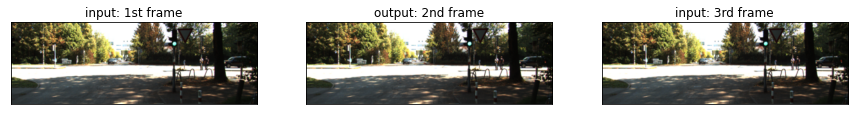

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
from glob import glob
import matplotlib.pyplot as plt

class Kitti_dataset(Dataset):

    def __init__(self, root=None, sequences=None, transform=None):
        self.transform = transform
        self.triplet_dirs_all = []
        for seq in sequences:
          for mono_folder in ['image_02', 'image_03']:
              full_dir = os.path.join(root, seq, mono_folder, 'data/*.png')
              print(full_dir)
              full_dir = os.path.join(root, seq, mono_folder, 'data/*.png')
              sorted_dirs = sorted(glob(full_dir))
              for idx in range(len(sorted_dirs[:-2])):
                  triplet_dirs = [sorted_dirs[idx], sorted_dirs[idx + 1], sorted_dirs[idx + 2]]
                  self.triplet_dirs_all.append(triplet_dirs)

    def __len__(self):
        return len(self.triplet_dirs_all)

    def __getitem__(self, index):
        img1 = Image.open(self.triplet_dirs_all[index][0]).convert('RGB')
        img2 = Image.open(self.triplet_dirs_all[index][1]).convert('RGB')
        img3 = Image.open(self.triplet_dirs_all[index][2]).convert('RGB')
        if self.transform:
            img1, img2, img3 = self.transform(img1), self.transform(img2), self.transform(img3)
        input = torch.concat([img1, img3])
        return input, img2
transform_all = transforms.Compose([
    transforms.Resize((128, 384)),
    transforms.ToTensor(),
])
root = 'kitti_raw/data'
sequences_train = ['2011_09_28_drive_0001_sync']
train_dataset = Kitti_dataset(root=root,sequences=sequences_train, transform=transform_all)
#valid_dataset = Kitti_dataset(root=root)

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
#valid_loader = DataLoader(valid_dataset, batch_size=args.valid_batch_size, shuffle=False, num_workers=2)

print("Sample size- Train:",len(train_dataset))
# Valid: %d"%(len(train_dataset), len(valid_dataset)))

(input, label) = train_dataset[0]
print('input:', input.shape, 'label:', label.shape)
num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(input[:3].permute(1,2,0))
ax[0].set_title('input: 1st frame')

ax[1].imshow(label.permute(1,2,0))
ax[1].set_title('output: 2nd frame')

ax[2].imshow(input[3:].permute(1,2,0))
ax[2].set_title('input: 3rd frame');
inputs = {}
inputs[("color", -1, 0)] = input[:3]
inputs[("color", 0, 0)] = label
inputs[("color", 1, 0)] = input[3:]

In [ ]:
# import gdown
# gdown.download('https://drive.google.com/uc?id=17k1-CHptG_XTXVX8qp7yK_zadH54vVnY','d3k1_video', quiet=True) 

In [ ]:
# import glob

# if os.path.isfile(args.image_path):
#     paths = [args.image_path]
#     output_directory = os.path.dirname(args.image_path)
# elif os.path.isdir(args.image_path):
#     paths = glob.glob(os.path.join(args.image_path, '*.{}'.format(args.ext)))
#     output_directory = args.image_path
# print(paths)

In [ ]:
#@title Default title text
import os
import cv2  


def video2frames(pathIn='',
                 pathOutL='',
                 pathOutR='',
                 only_output_video_info=False,
                 initial_extract_time=0,
                 end_extract_time=None,
                 extract_time_interval=-1,# default all, skip frames between time gap
                 output_prefix='frame',
                 jpg_quality=100,#0~100
                 isColor=True):
    cap = cv2.VideoCapture(pathIn) 
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  
    fps = cap.get(cv2.CAP_PROP_FPS) 
    dur = n_frames / fps 
    
    if only_output_video_info:# only info
        print("video: {} \nDuration of the video: {} seconds \nNumber of frames: {} \n".format(pathIn, dur, n_frames))

    else:# 
         
        try:
            os.mkdir(pathOutR)
            os.mkdir(pathOutL)
        except OSError:
            pass
        success = True
        count = 0
        while success:
            cap.set(cv2.CAP_PROP_POS_MSEC, (1000 * initial_extract_time + count * 1000 * extract_time_interval)) #Current position of the video file in milliseconds.
            success, image = cap.read()
            if success:
                if not isColor:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                #print('Write a new frame3: {}, {}th'.format(success, count + 1))
                h, w, _ = image.shape
                l_image = image[:h//2, :, :]
                r_image = image[h//2:, :, :]
                cv2.imwrite(os.path.join(pathOutL, "{}_{:06d}.jpg".format(output_prefix, count + 1)), l_image,
                            [int(cv2.IMWRITE_JPEG_QUALITY), jpg_quality]) 
                cv2.imwrite(os.path.join(pathOutR, "{}_{:06d}.jpg".format(output_prefix, count + 1)), r_image,
                            [int(cv2.IMWRITE_JPEG_QUALITY), jpg_quality]) 
                count = count + 1
      



#test

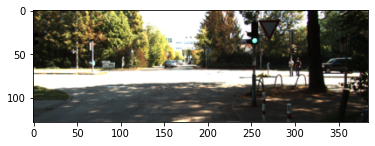

torch.Size([3, 128, 384])
128 384
torch.Size([1, 1, 128, 384])


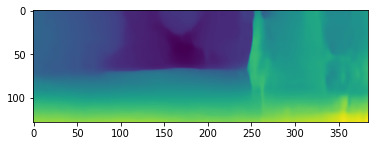

(128, 384)


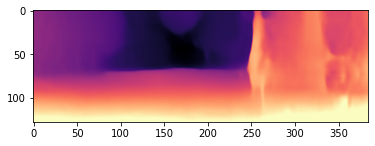

In [ ]:
import cv2
from PIL import Image
from torchvision import transforms
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

(input, label) = train_dataset[0]
plt.imshow(input[:3].permute(1,2,0)),plt.show()
input_image = input[:3]
print(input[:3].size())
original_width, original_height = input_image.size()[1], input_image.size()[2]
print(original_width, original_height)

input_image = input_image[None].to(device)
features = encoder(input_image)######encoder
outputs = depth_decoder(features)#####decoder
disp = outputs[("disp", 0)]########
print(disp.size())
plt.imshow(disp.squeeze().detach().numpy()), plt.show()###disparity

disp_resized = torch.nn.functional.interpolate(
    disp, (original_width, original_height), mode="bilinear", align_corners=False)
min_disp = 1 / 100 # max_depth=100 #diap_to_depth
max_disp = 1 / 0.1 # min_depth=0.1
scaled_disp = min_disp + (max_disp - min_disp) * disp
disp_resized_np = disp_resized.squeeze().detach().numpy()
print(disp_resized_np.shape)
vmax = np.percentile(disp_resized_np, 95)

normalizer = mpl.colors.Normalize(vmin=disp_resized_np.min(), vmax=vmax)
mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
colormapped_im = (mapper.to_rgba(disp_resized_np) [:, :, :3]* 255).astype(np.uint8)
im = Image.fromarray(colormapped_im)
plt.imshow(im)####normalized & colormapped depth map

In [ ]:
#@title Default title text
# #@title Default title text
# import cv2
# from PIL import Image
# from torchvision import transforms
# import matplotlib as mpl
# import matplotlib.cm as cm
# import matplotlib.pyplot as plt

# input_image = inputs_scared[('color_aug', 0, 0)]
# plt.imshow(input_image.permute(1,2,0)), plt.show()
# input_image = input_image[None]
# original_width, original_height = input_image.size()[2], input_image.size()[3]
# print(original_width, original_height)# (1280, 1024)

# input_image = input_image.to(device)
# features = encoder(input_image)#
# outputs = depth_decoder(features)#
# disp = outputs[("disp", 0)]
# plt.imshow(disp.squeeze().detach().numpy()), plt.show()

# disp_resized = torch.nn.functional.interpolate(
#     disp, (original_width, original_height), mode="bilinear", align_corners=False)
# min_disp = 1 / 100 # max_depth=100 #diap_to_depth
# max_disp = 1 / 0.1 # min_depth=0.1
# scaled_disp = min_disp + (max_disp - min_disp) * disp
# disp_resized_np = disp_resized.squeeze().detach().numpy()
# print(disp_resized_np.shape)
# vmax = np.percentile(disp_resized_np, 95)

# normalizer = mpl.colors.Normalize(vmin=disp_resized_np.min(), vmax=vmax)
# mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
# colormapped_im = (mapper.to_rgba(disp_resized_np) [:, :, :3]* 255).astype(np.uint8)
# im = Image.fromarray(colormapped_im)
# plt.imshow(im)

##pose

The pose encoder is modified to accept a pair of frames, or **six channels**, as input. It has has convolutional weights in the first layer of shape 6×64×3×3, instead of the **ResNet** default of 3×64×3×3. The first pre-trained filter tensor needs to be **duplicated along the channel dimension**.

The Pose decoder module is a fully convolutional network and it predicts the rotation using an axis-angle representation and **scale the rotation and translation** outputs by 0.01.

In [ ]:
#@title Default title text
def rot_from_axisangle(vec):
    """Convert an axisangle rotation into a 4x4 transformation matrix
    (adapted from https://github.com/Wallacoloo/printipi)
    Input 'vec' has to be Bx1x3
    """
    angle = torch.norm(vec, 2, 2, True)
    axis = vec / (angle + 1e-7)

    ca = torch.cos(angle)
    sa = torch.sin(angle)
    C = 1 - ca

    x = axis[..., 0].unsqueeze(1)
    y = axis[..., 1].unsqueeze(1)
    z = axis[..., 2].unsqueeze(1)

    xs = x * sa
    ys = y * sa
    zs = z * sa
    xC = x * C
    yC = y * C
    zC = z * C
    xyC = x * yC
    yzC = y * zC
    zxC = z * xC

    rot = torch.zeros((vec.shape[0], 4, 4)).to(device=vec.device)

    rot[:, 0, 0] = torch.squeeze(x * xC + ca)
    rot[:, 0, 1] = torch.squeeze(xyC - zs)
    rot[:, 0, 2] = torch.squeeze(zxC + ys)
    rot[:, 1, 0] = torch.squeeze(xyC + zs)
    rot[:, 1, 1] = torch.squeeze(y * yC + ca)
    rot[:, 1, 2] = torch.squeeze(yzC - xs)
    rot[:, 2, 0] = torch.squeeze(zxC - ys)
    rot[:, 2, 1] = torch.squeeze(yzC + xs)
    rot[:, 2, 2] = torch.squeeze(z * zC + ca)
    rot[:, 3, 3] = 1

    return rot

def get_translation_matrix(translation_vector):
    """Convert a translation vector into a 4x4 transformation matrix
    """
    T = torch.zeros(translation_vector.shape[0], 4, 4).to(device=translation_vector.device)

    t = translation_vector.contiguous().view(-1, 3, 1)

    T[:, 0, 0] = 1
    T[:, 1, 1] = 1
    T[:, 2, 2] = 1
    T[:, 3, 3] = 1
    T[:, :3, 3, None] = t

    return T

def transformation_from_parameters(axisangle, translation, invert=False):
    """Convert the network's (axisangle, translation) output into a 4x4 matrix
    """
    R = rot_from_axisangle(axisangle)
    t = translation.clone()

    if invert:
        R = R.transpose(1, 2)
        t *= -1

    T = get_translation_matrix(t)

    if invert:
        M = torch.matmul(R, T)
    else:
        M = torch.matmul(T, R)

    return M

input: torch.Size([6, 128, 384]) label: torch.Size([3, 128, 384])
dict_keys([0, -1, 1])
cat pose feature:  torch.Size([6, 128, 384])
frame_ids:  [0, -1, 1]
disp scale 1:  torch.Size([1, 1, 64, 192])
R matrix torch.Size([1, 2, 1, 3])
tensor([[[[ 9.8596e-05, -7.8868e-05,  3.8019e-05]],

         [[ 5.8840e-05,  1.7724e-05, -4.8453e-06]]]], grad_fn=<SliceBackward0>)
translation vector: torch.Size([1, 2, 1, 3])
tensor([[[[ 1.8466e-05, -2.6077e-06, -2.2889e-05]],

         [[-5.2726e-05,  1.9125e-05,  1.5111e-06]]]], grad_fn=<SliceBackward0>)
M:  torch.Size([1, 4, 4])
tensor([[[ 1.0000e+00, -3.7990e-05, -7.8808e-05,  1.8466e-05],
         [ 3.7990e-05,  1.0000e+00, -9.8521e-05, -2.6077e-06],
         [ 7.8808e-05,  9.8521e-05,  1.0000e+00, -2.2889e-05],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       grad_fn=<UnsafeViewBackward0>)


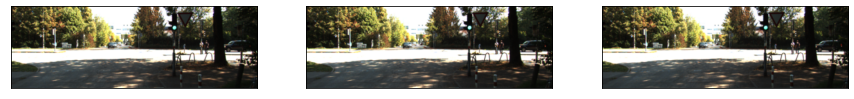

In [ ]:


#def predict_poses(inputs, features, disps):
"""Predict poses between input frames for monocular sequences.
"""
(input, label) = train_dataset[0]
print('input:', input.shape, 'label:', label.shape)
num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(input[:3].permute(1,2,0))#'input: 1st frame')
ax[1].imshow(label.permute(1,2,0))#'output: 2nd frame')
ax[2].imshow(input[3:].permute(1,2,0))#'input: 3rd frame');

#outputs = {}
#pose_feats = {f_i: inputs[("color_aug", f_i, 0)] for f_i in args.frame_ids}#[0, -1, 1]
pose_feats = {0:label, -1:input[:3], 1:input[3:]}#[0, -1, 1]
print(pose_feats.keys())
print("cat pose feature: ", torch.cat([pose_feats[0],pose_feats[1]],0).shape)
print("frame_ids: ", args.frame_ids)# [0, -1, 1]

for f_i in args.frame_ids[1:]: #[-1,1]

    if f_i < 0:#temporal order
        pose_inputs = [pose_feats[f_i], pose_feats[0]]
    else:
        pose_inputs = [pose_feats[0], pose_feats[f_i]]

    pose_inputs = [pose_encoder(torch.cat(pose_inputs, 0)[None])]####encoder

    axisangle, translation = pose_decoder(pose_inputs)#####decoder
    outputs[("axisangle", 0, f_i)] = axisangle
    outputs[("translation", 0, f_i)] = translation
    outputs[("cam_T_cam", 0, f_i)] = transformation_from_parameters(
        axisangle[:, 0], translation[:, 0])  #axisangle(2x3) -> R(4x4), translatioin(2x3) -> T(4x4), R&T -> M(4x4)
print("disp scale 1: ", outputs[("disp", 1)].shape)
print("R matrix", outputs[('axisangle', 0, -1)].shape)#torch.Size([1, 2, 1, 3])
print(outputs[('axisangle', 0, 1)])
print("translation vector:", outputs[('translation', 0, -1)].shape)#torch.Size([1, 2, 1, 3])
print(outputs[('translation', 0, 1)])
print("M: ", outputs[('cam_T_cam', 0, -1)].shape)#torch.Size([1, 4, 4])
print(outputs[('cam_T_cam', 0, 1)])

#reconstruction

1. To **back project each point of the target image to 3D space** according to depth and camera intrinsic;

2. To **project 3D points to image** plane according to camera extrinsic (pose) and intrinsic;

$p_{s} \sim K \hat{T}_{t \rightarrow s} \hat{D}_{t}\left(p_{t}\right) K^{-1} p_{t}$

$\left[\begin{array}{c}u \\v \\1\end{array}\right]=\frac{1}{z} \underbrace{\boldsymbol{K}}_{3 \times 3} \underbrace{[\boldsymbol{R} \mid \boldsymbol{t}]}_{3 \times 4}\left[\begin{array}{c}x \\y \\z \\1\end{array}\right]$

$\left[\begin{array}{c}u \\v \\1 \\1 / z\end{array}\right]=\frac{1}{z} \underbrace{\left[\begin{array}{cc}
K_{3 \times 3} & \mathbf{0} \\\mathbf{0} & 1\end{array}\right]}_{4 \times 4} \underbrace{\left[\begin{array}{cc}R_{3 \times 3} & t_{3 \times 1} \\0_{1 \times 3} & 1\end{array}\right]}_{4 \times 4}\left[\begin{array}{c}x \\y \\z \\1\end{array}\right], \boldsymbol{K}=\left[\begin{array}{ccc}f_{x} & S & c_{x} \\0 & f_{y} & c_{y} \\0 & 0 & 1\end{array}\right]$



3. **Sampling pixels from the source image** to reconstruct a new image according to the projected points (exploit Spatial Transformer Networks (STN) to ensure that the sampling is differentiable).


<img src="https://d3i71xaburhd42.cloudfront.net/3abf64d10a5d9a426d864bcfd68daed370d6904c/3-Figure3-1.png" alt="alt" width="30%"/>



In [ ]:
class BackprojectDepth(nn.Module):
    """Layer to transform a depth image into a point cloud
    """
    def __init__(self, batch_size, height, width):
        super(BackprojectDepth, self).__init__()

        self.batch_size = batch_size
        self.height = height
        self.width = width

        meshgrid = np.meshgrid(range(self.width), range(self.height), indexing='xy')#cartesiam coordinates
        self.id_coords = np.stack(meshgrid, axis=0).astype(np.float32)
        self.id_coords = nn.Parameter(torch.from_numpy(self.id_coords),
                                      requires_grad=False)#learnable parameters

        self.ones = nn.Parameter(torch.ones(self.batch_size, 1, self.height * self.width),
                                 requires_grad=False)

        self.pix_coords = torch.unsqueeze(torch.stack(
            [self.id_coords[0].view(-1), self.id_coords[1].view(-1)], 0), 0)
        self.pix_coords = self.pix_coords.repeat(batch_size, 1, 1)
        self.pix_coords = nn.Parameter(torch.cat([self.pix_coords, self.ones], 1),
                                       requires_grad=False)

    def forward(self, depth, inv_K):
        print('-------------pixel -> camera -> depth---------------')
        cam_points = torch.matmul(inv_K[:, :3, :3], self.pix_coords)#[3,3][] #drop last colomn and last row
        print('pixel: ', pix_coords.size(), 'k_inv: ', inv_K[:, :3, :3].size(),'cam: ',cam_points.size(), 'depth:',depth.view(self.batch_size, 1, -1).size())
        cam_points = depth.view(self.batch_size, 1, -1) * cam_points #camera multiply depth
        cam_points = torch.cat([cam_points, self.ones], 1) 

        return cam_points


class Project3D(nn.Module):
    """Layer which projects 3D points into a camera with intrinsics K and at position T
    """
    def __init__(self, batch_size, height, width, eps=1e-7):
        super(Project3D, self).__init__()

        self.batch_size = batch_size
        self.height = height
        self.width = width
        self.eps = eps

    def forward(self, points, K, T):
        P = torch.matmul(K, T)[:, :3, :] #K multiply T
        print('-----------world -> camera -> pixel-------------')
        cam_points = torch.matmul(P, points) #K multiply T multiply points, from world to camera then to image
        print('KT: ', P.size(), 'point cloud: ', points.size(), '3d to 2d: ', cam_points.size())
        #cam_points to pixel coords: torch.Size([1, 3, 49152])#torch.Size([1, 2, 49152])#torch.Size([1, 1, 49152])
        pix_coords = cam_points[:, :2, :] / (cam_points[:, 2, :].unsqueeze(1) + self.eps)#+ self.eps barely no change
        print('pixel coordinate: ', cam_points.shape)
        pix_coords = pix_coords.view(self.batch_size, 2, self.height, self.width)
        print('pix coordinate view batch, 2, h, w', pix_coords.shape)
        pix_coords = pix_coords.permute(0, 2, 3, 1)#batch, h, w, 2
        pix_coords[..., 0] /= self.width - 1 #a[...,0]==a[:,:,0])
        pix_coords[..., 1] /= self.height - 1 # 
        pix_coords = (pix_coords - 0.5) * 2
        return pix_coords

def disp_to_depth(disp, min_depth, max_depth):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth

intrinsic parameter:  tensor([[[ 4.4899e-03, -6.6886e-11, -8.6207e-01,  0.0000e+00],
         [-1.2011e-10,  4.0690e-03, -2.6042e-01,  0.0000e+00],
         [-4.4222e-10, -1.0485e-10,  1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]])
intrinsic parameter:  tensor([[[ 4.4899e-03, -6.6886e-11, -8.6207e-01],
         [-1.2011e-10,  4.0690e-03, -2.6042e-01],
         [-4.4222e-10, -1.0485e-10,  1.0000e+00]]])
disp:  torch.Size([1, 1, 128, 384]) depth:  torch.Size([1, 1, 128, 384])
-------------pixel -> camera -> depth---------------
pixel:  torch.Size([1, 128, 384, 2]) k_inv:  torch.Size([1, 3, 3]) cam:  torch.Size([1, 3, 49152]) depth: torch.Size([1, 1, 49152])
3d:  torch.Size([1, 4, 49152])
-----------world -> camera -> pixel-------------
KT:  torch.Size([1, 3, 4]) point cloud:  torch.Size([1, 4, 49152]) 3d to 2d:  torch.Size([1, 3, 49152])
pixel coordinate:  torch.Size([1, 3, 49152])
pix coordinate view batch, 2, h, w torch.Size([1, 2, 128, 384])

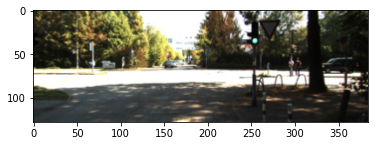

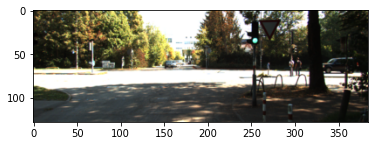

In [ ]:
backproject_depth = {}
project_3d = {}
scales=range(4)
width = 384
height = 128
K = np.array([[0.58, 0, 0.5, 0],
              [0, 1.92, 0.5, 0],
              [0,    0,   1, 0],
              [0,    0,   0, 1]], dtype=np.float32)
for scale in scales:
    h = height // (2 ** scale)
    w = width // (2 ** scale)  

    backproject_depth[scale] = BackprojectDepth(1, h, w)#batch size
    backproject_depth[scale].to(device)

    project_3d[scale] = Project3D(1, h, w)
    project_3d[scale].to(device)     

    K = K.copy()
    K[0, :] *= width // (2 ** scale)
    K[1, :] *= height // (2 ** scale)

    inv_K = np.linalg.pinv(K)
    inputs[("K", scale)] = torch.from_numpy(K)
    inputs[("inv_K", scale)] = torch.from_numpy(inv_K)

#print(inputs[("K", 1)].size())#torch.Size([4, 4])
#print("K matrix: ", inputs[("K", 1)][None][:, :3, :3])#drop last column and last row
# tensor([[4.2762e+04, 0.0000e+00, 3.6864e+04, 0.0000e+00],
#         [0.0000e+00, 1.5729e+04, 4.0960e+03, 0.0000e+00],
#         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
#         [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]])
print('intrinsic parameter: ', inputs[("inv_K", 0)][None])#torch.Size([4, 4])
print('intrinsic parameter: ', inputs[("inv_K", 0)][None][:, :3, :3])#torch.Size([4, 4])


#generate_images_pred(inputs, outputs) #outputs have {("disp"):, ("axisangle"):, ("translation"):}

scale = 0
disp = outputs[("disp", scale)]
source_scale = scale
_, depth = disp_to_depth(disp, 0.1, 100) 
print('disp: ',disp.size(),"depth: ", depth.size())#torch.Size([1, 1, 128, 384])
outputs[("depth", 0, scale)] = depth######

for i, frame_id in enumerate(args.frame_ids[1:]):

    T = outputs[("cam_T_cam", 0, frame_id)] 
    axisangle = outputs[("axisangle", 0, frame_id)]
    translation = outputs[("translation", 0, frame_id)]
    inv_depth = 1 / depth
    mean_inv_depth = inv_depth.mean(3, True).mean(2, True)
    cam_points = backproject_depth[source_scale](
        depth, inputs[("inv_K", source_scale)][None])   # 2d depth to 3d point cloud     
    print('3d: ', cam_points.size())
    pix_coords = project_3d[source_scale](
        cam_points, inputs[("K", source_scale)][None], T)# 3d point cloud to 2d
    print('2d: ', pix_coords.size())
    outputs[("sample", frame_id, scale)] = pix_coords #2d reconstruction
    
    outputs[("color", frame_id, scale)] = F.grid_sample(
        inputs[("color", frame_id, source_scale)][None],
        outputs[("sample", frame_id, scale)],
        padding_mode="border") #warping
    ##########input N,C,H_in,W_in , grid N,H_out,W_out,2
print('output: ', outputs[("sample", frame_id, scale)].size())
plt.imshow(outputs[("color", frame_id, scale)].squeeze().permute(1,2,0).detach().numpy()),plt.show()
plt.imshow(inputs[("color", frame_id, scale)].squeeze().permute(1,2,0).detach().numpy())



In [ ]:
from torchmetrics import StructuralSimilarityIndexMeasure

class SSIM(nn.Module):

    def __init__(self):
        super(SSIM, self).__init__()

        self.mu_x_pool   = nn.AvgPool2d(3, 1)
        self.mu_y_pool   = nn.AvgPool2d(3, 1)
        self.sig_x_pool  = nn.AvgPool2d(3, 1)
        self.sig_y_pool  = nn.AvgPool2d(3, 1)
        self.sig_xy_pool = nn.AvgPool2d(3, 1)

        self.refl = nn.ReflectionPad2d(1)

        self.C1 = 0.01 ** 2
        self.C2 = 0.03 ** 2

    def forward(self, x, y):
        x = self.refl(x)
        y = self.refl(y)

        mu_x = self.mu_x_pool(x)                            # x
        mu_y = self.mu_y_pool(y)                            # y local mean
        sigma_x  = self.sig_x_pool(x ** 2) - mu_x ** 2      # x local variance D(X)=E(X^2)-E(X)^2
        sigma_y  = self.sig_y_pool(y ** 2) - mu_y ** 2      # y
        sigma_xy = self.sig_xy_pool(x * y) - mu_x * mu_y    # covariance  D(XY)=E(X*Y)-E(X)*E(Y)

        SSIM_n = (2 * mu_x * mu_y + self.C1) * (2 * sigma_xy + self.C2)
        SSIM_d = (mu_x ** 2 + mu_y ** 2 + self.C1) * (sigma_x + sigma_y + self.C2)

        # clamp(input, min, max, out=None) ： 
        return torch.clamp((1 - SSIM_n / SSIM_d) / 2, 0, 1)

def compute_reprojection_loss( pred, target):

    abs_diff = torch.abs(target - pred)    
    l1_loss = abs_diff.mean(1, True)      #mean on dim 1 

    if False:#self.opt.no_ssim:
        reprojection_loss = l1_loss
    else:
        ssim_loss = SSIM()(pred, target).mean(1, True)
        reprojection_loss = 0.85 * ssim_loss + 0.15 * l1_loss

    return reprojection_loss

pred = outputs[("color", frame_id, scale)].squeeze().permute(1,2,0)
targ = inputs[("color", frame_id, scale)].squeeze().permute(1,2,0)
print(compute_reprojection_loss(pred, targ).size())
print(torch.mean(compute_reprojection_loss(pred, targ)))

torch.Size([128, 1, 3])
tensor(0.0218, grad_fn=<MeanBackward0>)


##evaluate pose

In [ ]:
# Copyright Niantic 2019. Patent Pending. All rights reserved.
#
# This software is licensed under the terms of the Monodepth2 licence
# which allows for non-commercial use only, the full terms of which are made
# available in the LICENSE file.

from __future__ import absolute_import, division, print_function

import os
import numpy as np

import torch
from torch.utils.data import DataLoader

from layers import transformation_from_parameters
from utils import readlines
from options import MonodepthOptions
from datasets import KITTIOdomDataset
import networks


# from https://github.com/tinghuiz/SfMLearner
def dump_xyz(source_to_target_transformations):
    xyzs = []
    cam_to_world = np.eye(4)
    xyzs.append(cam_to_world[:3, 3])
    for source_to_target_transformation in source_to_target_transformations:
        cam_to_world = np.dot(cam_to_world, source_to_target_transformation)
        xyzs.append(cam_to_world[:3, 3])
    return xyzs


# from https://github.com/tinghuiz/SfMLearner
def compute_ate(gtruth_xyz, pred_xyz_o):

    # Make sure that the first matched frames align (no need for rotational alignment as
    # all the predicted/ground-truth snippets have been converted to use the same coordinate
    # system with the first frame of the snippet being the origin).
    offset = gtruth_xyz[0] - pred_xyz_o[0]
    pred_xyz = pred_xyz_o + offset[None, :]

    # Optimize the scaling factor
    scale = np.sum(gtruth_xyz * pred_xyz) / np.sum(pred_xyz ** 2)
    alignment_error = pred_xyz * scale - gtruth_xyz
    rmse = np.sqrt(np.sum(alignment_error ** 2)) / gtruth_xyz.shape[0]
    return rmse


def evaluate(opt):
    """Evaluate odometry on the KITTI dataset
    """
    assert os.path.isdir(opt.load_weights_folder), \
        "Cannot find a folder at {}".format(opt.load_weights_folder)

    assert opt.eval_split == "odom_9" or opt.eval_split == "odom_10", \
        "eval_split should be either odom_9 or odom_10"

    sequence_id = int(opt.eval_split.split("_")[1])

    filenames = readlines(
        os.path.join(os.path.dirname(__file__), "splits", "odom",
                     "test_files_{:02d}.txt".format(sequence_id)))

    dataset = KITTIOdomDataset(opt.data_path, filenames, opt.height, opt.width,
                               [0, 1], 4, is_train=False)
    dataloader = DataLoader(dataset, opt.batch_size, shuffle=False,
                            num_workers=opt.num_workers, pin_memory=True, drop_last=False)

    pose_encoder_path = os.path.join(opt.load_weights_folder, "pose_encoder.pth")
    pose_decoder_path = os.path.join(opt.load_weights_folder, "pose.pth")

    pose_encoder = networks.ResnetEncoder(opt.num_layers, False, 2)
    pose_encoder.load_state_dict(torch.load(pose_encoder_path))

    pose_decoder = networks.PoseDecoder(pose_encoder.num_ch_enc, 1, 2)
    pose_decoder.load_state_dict(torch.load(pose_decoder_path))

    pose_encoder.cuda()
    pose_encoder.eval()
    pose_decoder.cuda()
    pose_decoder.eval()

    pred_poses = []

    print("-> Computing pose predictions")

    opt.frame_ids = [0, 1]  # pose network only takes two frames as input

    with torch.no_grad():
        for inputs in dataloader:
            for key, ipt in inputs.items():
                inputs[key] = ipt.cuda()

            all_color_aug = torch.cat([inputs[("color_aug", i, 0)] for i in opt.frame_ids], 1)

            features = [pose_encoder(all_color_aug)]
            axisangle, translation = pose_decoder(features)

            pred_poses.append(
                transformation_from_parameters(axisangle[:, 0], translation[:, 0]).cpu().numpy())

    pred_poses = np.concatenate(pred_poses)

    gt_poses_path = os.path.join(opt.data_path, "poses", "{:02d}.txt".format(sequence_id))
    gt_global_poses = np.loadtxt(gt_poses_path).reshape(-1, 3, 4)
    gt_global_poses = np.concatenate(
        (gt_global_poses, np.zeros((gt_global_poses.shape[0], 1, 4))), 1)
    gt_global_poses[:, 3, 3] = 1
    gt_xyzs = gt_global_poses[:, :3, 3]

    gt_local_poses = []
    for i in range(1, len(gt_global_poses)):
        gt_local_poses.append(
            np.linalg.inv(np.dot(np.linalg.inv(gt_global_poses[i - 1]), gt_global_poses[i])))

    ates = []
    num_frames = gt_xyzs.shape[0]
    track_length = 5
    for i in range(0, num_frames - 1):
        local_xyzs = np.array(dump_xyz(pred_poses[i:i + track_length - 1]))
        gt_local_xyzs = np.array(dump_xyz(gt_local_poses[i:i + track_length - 1]))

        ates.append(compute_ate(gt_local_xyzs, local_xyzs))

    print("\n   Trajectory error: {:0.3f}, std: {:0.3f}\n".format(np.mean(ates), np.std(ates)))

    save_path = os.path.join(opt.load_weights_folder, "poses.npy")
    np.save(save_path, pred_poses)
    print("-> Predictions saved to", save_path)


if __name__ == "__main__":
    options = MonodepthOptions()
    evaluate(options.parse())
